In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
from sklearn.model_selection import KFold
import pickle

from notebooks.imports import *
from config import dir_config
from src.utils import pmf_utils, glm_hmm_utils

In [3]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

In [21]:
_TRIALS = "all_trials"
# _TRIALS = "all_trials_eq_prior"

data_path = f"glm_hmm_{_TRIALS}_final.pkl"
if "eq_prior" in _TRIALS:
	eq_only = True
else:
	eq_only = False

n_trial_back = 1

state_prob_threshold = 0.75

In [ ]:
with open(Path(processed_dir, data_path), "rb") as f:
	glm_hmm = pickle.load(f)
models = glm_hmm["model"]["models"]
data = glm_hmm["data"]

session_metadata = pd.read_csv(Path(processed_dir, "sessions_metadata.csv"))

## Distribution of number of switches

In [17]:
def calculate_posterior_prob(model, data):
	if "no_bias" in _TRIALS:
		input = np.array(
			data[
				["normalized_stimulus"] +
				[f"prev_choice_{t+1}" for t in range(n_trial_back)] +
				[f"prev_target_{t+1}" for t in range(n_trial_back)]
			]
		)
	else:
		input = np.array(
			data[
				["normalized_stimulus", "bias"] +
				[f"prev_choice_{t+1}" for t in range(n_trial_back)] +
				[f"prev_target_{t+1}" for t in range(n_trial_back)]
			]
		)
	return model.expected_states(data=data["choices"].values.reshape(-1, 1), input=input, mask=np.array(data["mask"].values.reshape(-1, 1)))[0]

In [50]:
def get_switch_number(posterior_prob):
    state_1_trials = posterior_prob[:,0] > state_prob_threshold
    state_2_trials = posterior_prob[:,1] > state_prob_threshold
    trial_states = np.full(posterior_prob.shape[0], np.nan)
    # return state_1_trials, state_2_trials, trial_states
    trial_states[state_1_trials] = 1
    trial_states[state_2_trials] = 2

    # ignore nan(transitioning) trials
    high_confidence_state_mask = ~np.isnan(trial_states)
    state_diff = np.diff(trial_states[high_confidence_state_mask])
    switch_time = np.where(high_confidence_state_mask)[0][np.where(state_diff)[0]+1]
    return switch_time

In [ ]:
posterior_probs = {}
relative_switch_times = {}
switch_stats = {"relative_times":{}, "num_of_switches":[]}
relative_posterior_prob = np.full((600,len(session_metadata)),np.nan)

for session_idx, session in enumerate(session_metadata["session_id"]):
	model = models[session]
	session_data = data[session]
	prob_toRF = session_data["prob_toRF"][session_data["mask"]]
	indices = np.where((prob_toRF != 50) & ~np.isnan(prob_toRF))[0]
	block_switch = indices[0] if len(indices) > 0 else 0
	posterior_probs[session] = calculate_posterior_prob(model, session_data)
	switch_times= get_switch_number(posterior_probs[session])
	switch_stats["relative_times"][session] = switch_times - block_switch
	switch_stats["num_of_switches"].append(len(switch_times))

	relative_posterior_prob[:,session_idx] = posterior_probs[session][block_switch-100: block_switch+500, 0]


(array([31.,  2.,  5.,  1.,  3.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.]),
 array([ 1.    ,  1.9375,  2.875 ,  3.8125,  4.75  ,  5.6875,  6.625 ,
         7.5625,  8.5   ,  9.4375, 10.375 , 11.3125, 12.25  , 13.1875,
        14.125 , 15.0625, 16.    ]),
 <BarContainer object of 16 artists>)

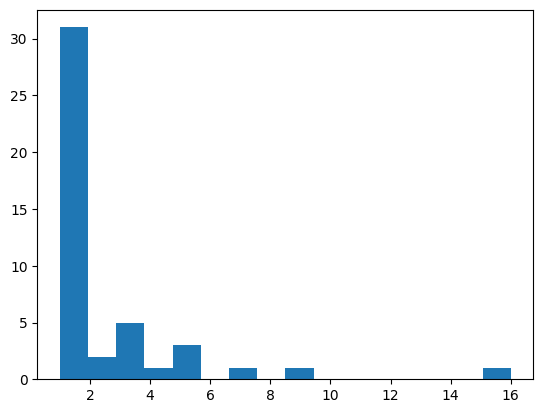

In [ ]:
plt.figure()
plt.hist(switch_stats["num_of_switches"],bins = 16)
plt.show()

## Time course of switch

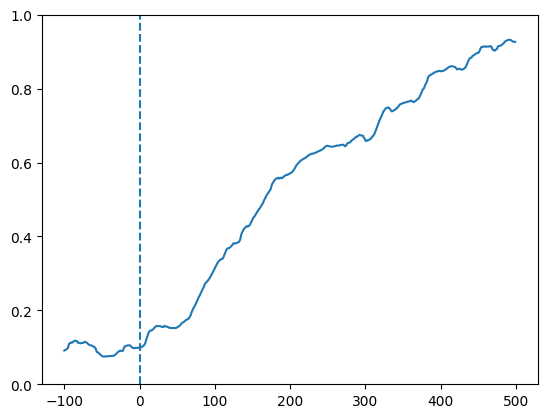

In [88]:
plt.figure()
plt.plot(np.arange(-100,500), np.nanmean(relative_posterior_prob, axis=1))

plt.ylim([0,1])
plt.vlines(0,0,1,linestyles='dashed')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Average time to switch

In [ ]:
plt.figure()
plt.hist(switch_stats["num_of_switches"],bins = 16)
plt.show()

## Percentage of state occupancy in two blocks